# Imports

In [3]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
pd.set_option('float_format', '{:f}'.format)
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 40)
# pd.set_option('display.width', 1000)
from qgrid import show_grid

import pandas_bokeh
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import style
style.use('fivethirtyeight')
mpl.rcParams['figure.figsize'] = [20, 7]

from data_api import polygon_df as pdf
from data_model import arrow_dataset as pds
from data_model import s3_backend as ps3
from market_cluster import preprocess as mp
# from market_cluster import cov as mcov
from market_cluster import cluster as mc
from utilities.pickle import pickle_dump, pickle_load

# import ipdb
# ipdb.set_trace(context=10)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
tdf = ps3.fetch_clean_trades(symbol='GLD',date='2020-01-02')

GLD 2020-01-02 trying to get data from local file...


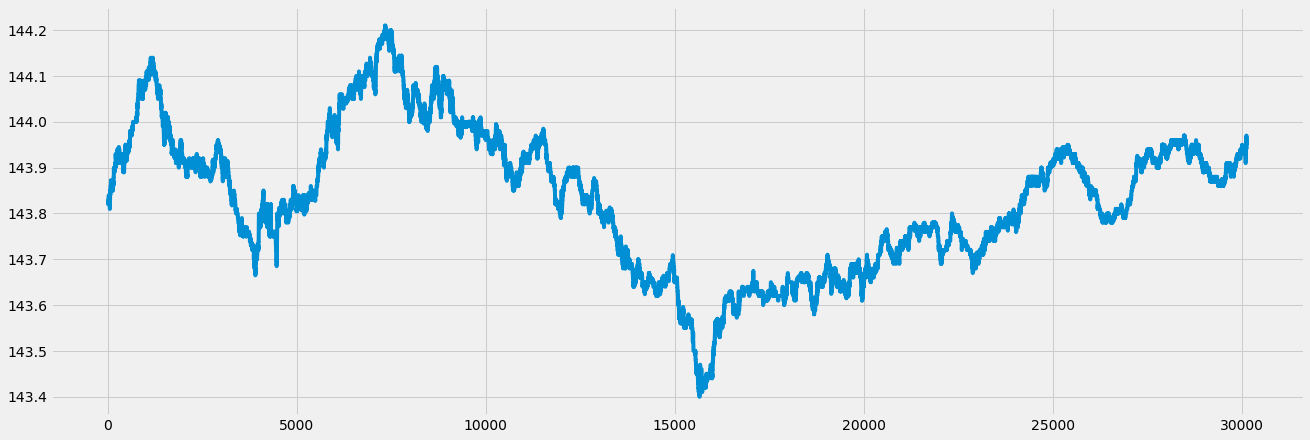

In [19]:
tdf.price.plot()

# Cluster market symbols

In [ ]:
# load and pre-process market daily data

start_date = '2018-10-24'
end_date = '2020-11-24'

# r = mp.prepare_data(start_date, end_date, beta_symbol='VTI')

# pickle_dump(r, 'data/r.pkl')
r = pickle_load('/Users/bobcolner/QuantClarity/pandas-polygon/data/r.pkl')

In [ ]:
# cluster dataset

X = r['g_zs_log_returns_resid']
Xt = X.transpose()
gt_industry = r['symbol_meta'].industry.values
gt_sector = r['symbol_meta'].sector.values

# compute covariance/correlation/distance/similarity matrics

dist_mat, cor_mat = mcov.cov_denoise_detone_dist(X, detone=False)
abs_cor_mat = abs(cor_mat)

In [ ]:
# fit cluster models and evalue vs. ground truth labels

kclust = mc.cluster_ground_truth_eval(mc.get_kmean_clusters, 200, Xt, gt_industry)
print(kclust['adj. multual information'])

hclust = mc.cluster_ground_truth_eval(mc.get_hira_clusters, 200, Xt, gt_industry)
print(hclust['adj. multual information'])
# k=100
# 0.40230760295593404
# 0.4357061244632522

# k=200
# 0.40757595584237727
# 0.4304010633801613

In [ ]:
kcclust = mc.cluster_ground_truth_eval(mc.get_kmean_constrained_clusters, 200, Xt, gt_industry)
print(kcclust['adj. multual information'])
# k=200
# 0.380596359954724

In [ ]:
# compute cluster descriptive stats

cluster_df = mc.cluster_metrics(lables=hclust['cluster_labels'], dist_mat=dist_mat, sym_meta=r['symbol_meta'])

cluster_df.cluster_size.hist(bins=20)

In [ ]:
# cluster filters

out = cluster_df

size_mask = (out.cluster_size > 5)

similartiy_mask = out.avg_similartiy > out.avg_similartiy.quantile(q=0.25)

sector_purity_mask = out.sector_purity > out.sector_purity.quantile(q=0.25)

industry_purity_mask = out.industry_purity > out.industry_purity.quantile(q=0.25)

range_value_mask = out.avg_range_value_pct > out.avg_range_value_pct.quantile(q=0.25)

out_f = out[range_value_mask & similartiy_mask].sort_values('avg_similartiy', ascending=False)[:9]

In [ ]:
show_grid(out.drop(columns=['symbols_dist_df','symbols_meta_df']))

In [ ]:
show_grid(cluster_df.iloc[1].symbols_meta_df)

# Corex

In [ ]:
import market_corex as corex

# corex200 = up.pickle_load('data/corex200.pkl')

corex, full_df = corex.corex_fit(X, n_hidden=200)

# up.pickle_dump((corex, full_df), file_name='corex200.pkl')

# gsutil copy /Users/bobcolner/QuantClarity/pandas-polygon/corex200.pkl gs://emerald-skill-datascience/

# GLRM

In [ ]:
import h2o
from h2o.estimators import H2OGeneralizedLowRankEstimator
h2o.init()

# Import the USArrests dataset into H2O:
arrestsH2O = h2o.import_file("https://s3.amazonaws.com/h2o-public-test-data/smalldata/pca_test/USArrests.csv")

# Split the dataset into a train and valid set:
train, valid = arrestsH2O.split_frame(ratios=[.8], seed=1234)

# Build and train the model:
glrm_model = H2OGeneralizedLowRankEstimator(
    k=4,
    loss="Huber",
    loss_by_col={'cat_var': 'Categorical'},
    regularization_x="OneSparse", # None (default), Quadratic, L2, L1, NonNegative, OneSparse, UnitOneSparse, Simplex.
    regularization_y="OneSparse",
    gamma_x=0.5,
    gamma_y=0.5,
    max_iterations=1000,
    recover_svd=True,
    init="PlusPlus",
    transform="standardize",
   )
glrm_model.train(training_frame=train)